In [1]:
import os
import re
import glob
import math
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, savgol_filter, convolve, peak_prominences
from peak_metrics import *
from utils import *

In [2]:
CSVs = []
for root, dirs, files in os.walk("Affinity Data"):
    for file in files:
        if file.endswith(".csv"):
             CSVs.append(os.path.join(root, file))

In [59]:
len(CSVs)

377

In [3]:
def show_peaks(name, uv_280, volume, peaks, half_width, contour_heights):
    plt.rcParams["figure.figsize"] = (20,10)
    # plt.plot(uv_280)
    # plt.plot(peaks, uv_280[peaks], "x")
    plt.plot(volume, uv_280)
    plt.plot(volume[peaks], uv_280[peaks], "x")
    #plt.plot(np.zeros_like(uv_280), "--", color="gray")
    plt.hlines(y=0, xmin=min(volume), xmax=max(volume), linestyle="dashed", color="gray" )
    plt.hlines(*half_width, color="C2")
    plt.vlines(x=volume[peaks], ymin=contour_heights, ymax=uv_280[peaks])
    plt.savefig(f'inspect_plots/{name}.png')
    plt.clf()

In [4]:
def query_line(volume, results):
    row_0 = [i for i in results[0]]
    row_1 = [volume[round(i)] for i in results[1]]
    row_2 = [volume[round(i)] for i in results[2]]
    return [row_0, row_1, row_2]

In [5]:
def get_start_stop_idx(dataframe):

   #   if 'Elution' not in dataframe['Logbook'].values:
   #      #  print(dataframe['Logbook'].values)
   #       elution_idx = dataframe.index[dataframe['Logbook'] == 'Elution 1'].tolist()[-1]
   #   else:
   #      elution_idx = dataframe.index[dataframe['Logbook'] == 'Elution'].tolist()[-1]

   #   column_wash_idx = dataframe.index[dataframe['Logbook'] == 'Column Wash'].tolist()[-1]
    try:
        log_vals = dataframe['Logbook'].values
    
        if 'Elution' in log_vals:
            elution_idx = dataframe.index[dataframe['Logbook'] == 'Elution'].tolist()[-1]
        elif 'Elution 1' in log_vals:
            elution_idx = dataframe.index[dataframe['Logbook'] == 'Elution 1'].tolist()[-1]
        else:
            elution_idx = None
        
        if 'Column Wash' in dataframe['Logbook'].values:
            column_wash_idx = dataframe.index[dataframe['Logbook'] == 'Column Wash'].tolist()[-1]
        elif 'Column Wash 1' in dataframe['Logbook'].values:
            column_wash_idx = dataframe.index[dataframe['Logbook'] == 'Column Wash 2'].tolist()[-1]
        else:
            column_wash_idx = None

        if 'Column CIP' in dataframe['Logbook'].values:
            stop_idx = dataframe.index[dataframe['Logbook'] == 'Column CIP'].tolist()[-1]
        else:
            stop_idx = None
    except:
        start_idx = None
        stop_idx = None
        
    if elution_idx != None:
        start_idx = elution_idx
    else:
        start_idx = column_wash_idx
    return start_idx, stop_idx


In [10]:
frame = {'file': [], 'Tailing Factor': [], 'Peak Assymetry': [], 'No. Theoretical Plates': [], 'Area (mAU*ml)':[]} #, 'Height':[]}

count = 0
errors = []
for csv in CSVs:
    name = csv.split('/')[-1][:-4]
    resin, serotype = get_resin_and_serotype(name)
    if resin == 'U':
        resin = get_resin(name)
    if serotype == 'U':
        serotype = csv.split('/')[1]
    # print(csv)
    try:
        df = pd.read_csv(csv, skiprows = [0,1], delimiter='\t', encoding='utf_16', on_bad_lines='skip', low_memory=False)
    except Exception as e:
        print(e, csv)

    try:

        # column_wash_idx, cip_idx = get_elution_and_cip_idx(df)
        start_idx, stop_idx = get_start_stop_idx(df)

        data = load_useful_data(df)

        # if column_wash_idx != None and cip_idx != None:
        #     count += 1
        #     start_column_wash = df[data['Run Log']].loc[column_wash_idx].values[0]
        #     start_clean = df[data['Run Log']].loc[cip_idx].values[0]
        if start_idx != None and stop_idx != None:
            count += 1
            start = df[data['Run Log']].loc[start_idx].values[0]
            stop = df[data['Run Log']].loc[stop_idx].values[0]

            
            cols = df[data['UV_280']].columns
            volume = df[data['UV_280']][cols[0]]
            uv_280 = df[data['UV_280']][cols[1]]

            volume = volume.apply(lambda x: 0 if x < start else x)
            volume = volume.apply(lambda x: 0 if x > stop else x)
            volume = volume.loc[volume > 0]

            uv_280 = uv_280[volume.index]
            uv_280  = uv_280.apply(lambda x: 0 if x < 0 else x)
            uv_280 = uv_280.loc[uv_280 > 0]
            uv_280.dropna(inplace=True)
            volume = volume.loc[uv_280.index]
            uv_280.reset_index(drop=True, inplace=True)
            volume.reset_index(drop=True, inplace=True)
            peaks, info = find_peaks(uv_280, height=10, width=15)
            results_half = peak_widths(uv_280, peaks, rel_height=0.5)
            results_full = peak_widths(uv_280, peaks, rel_height=1)
            results_five_pec = peak_widths(uv_280, peaks, rel_height=0.95)
            results_ten_pec = peak_widths(uv_280, peaks, rel_height=0.9)
            prominences = peak_prominences(uv_280, peaks)[0]
            contour_heights = uv_280[peaks] - prominences

            half_width = query_line(volume, results_half[1:])
            full_width = query_line(volume, results_full[1:])
            ten_percent_width = query_line(volume, results_ten_pec[1:])
            five_percent_width = query_line(volume, results_five_pec[1:])
            frame['file'].append(name)
            frame['Tailing Factor'].append(tailing_factor(peaks, results_five_pec[1:]))
            frame['Peak Assymetry'].append(peak_assymetry(peaks, results_ten_pec[1:]))
            frame['No. Theoretical Plates'].append(number_of_theoretical_plates(volume, peaks, results_half[1:]))
            frame['Area (mAU*ml)'].append(area(volume, peaks, results_full[1:], prominences))
            show_peaks(name, uv_280, volume, peaks, half_width, contour_heights)
    except Exception as e:
        print(e, csv)


data = pd.DataFrame(frame)

local variable 'elution_idx' referenced before assignment Affinity Data/AAVX/AAVX 0.5ML Run SAS102122 004_fl.csv
min() arg is an empty sequence Affinity Data/AAVX_2/AAVX HEK293 0.1mL column DBC Study Part II - 033121 SAS 050821 001.csv
min() arg is an empty sequence Affinity Data/AAVX_2/AAVX HEK293 4mL column No Storage Method for Queue- SAS072822 004_1.csv
min() arg is an empty sequence Affinity Data/AAVX_2/AAVX HEK293 4mL column with Empty AAV2 - SAS012422 001.csv
local variable 'elution_idx' referenced before assignment Affinity Data/AAVX_2/Column Evaluation - AAVx 2ml SAS-AM012921.csv
local variable 'elution_idx' referenced before assignment Affinity Data/AAVX_2/AAVX Resin For NCTM - 1ml Column HETP and ASYM.csv


<Figure size 2000x1000 with 0 Axes>

In [11]:
data.to_csv('peak_metrics.csv', index=False)

In [9]:
data

{'pH': ['ml.3', 'pH'],
 'UV_280': ['ml', 'mAU'],
 'UV_260': ['ml.2', 'mAU.1'],
 'Conductivity': ['ml.1', 'mS/cm'],
 'Sample Flow': ['ml.18', 'CV/h'],
 'System_flow': ['ml.19', 'CV/h.1'],
 'Sample Pressure': ['ml.9', 'MPa'],
 'System Pressure': ['ml.10', 'MPa.1'],
 'Run Log': ['ml.5', 'Logbook']}

In [127]:
!rm -rf inspect_plots
!mkdir inspect_plots

In [12]:
csv = 'Affinity Data/AAV2/New AAV2/AAV2 Pure in PBS - A10 Toyo 091223 002.csv'
dat = pd.read_csv(csv, skiprows = [0,1], delimiter='\t', encoding='utf_16', on_bad_lines='skip', low_memory=False)

data = load_useful_data(dat)
data['Run Log']

def plot_data(data, data_dict, columns=['UV_280', 'Conductivity']):
    """
    This function takes in a dataframe and plots the data.
    Args:
        data: dataframe
        folder: folder to save the plots
        name: name of the plot
        data_dict: dictionary with useful data
        columns: list of columns to plot
    Returns:
        None"""
    plt.rcParams["figure.figsize"] = (20,10)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(data[data_dict[columns[0]][0]], data[data_dict[columns[0]][1]], 'g-', label=columns[0])
    ax2.plot(data[data_dict[columns[0]][0]], data[data_dict[columns[1]][1]], 'b-', label=columns[1]) 
    ax1.set_xlabel('Volume (ml)')
    ax1.set_ylabel('mAU', color='g')
    ax2.set_ylabel('mS/cm', color='b')
    # resin, serotype = get_resin_and_serotype(name)
    # plt.title(f'Resin: {resin}, Serotype: {serotype}')
    plt.legend()
    plt.xticks(np.arange(min(data[data_dict[columns[0]][0]]), max(data[data_dict[columns[0]][0]])+1, 5))
    plt.show()
    # fig.savefig(f'{folder}/plots/{name}.png')
    # fig.clf()
    # fig.clear()
    

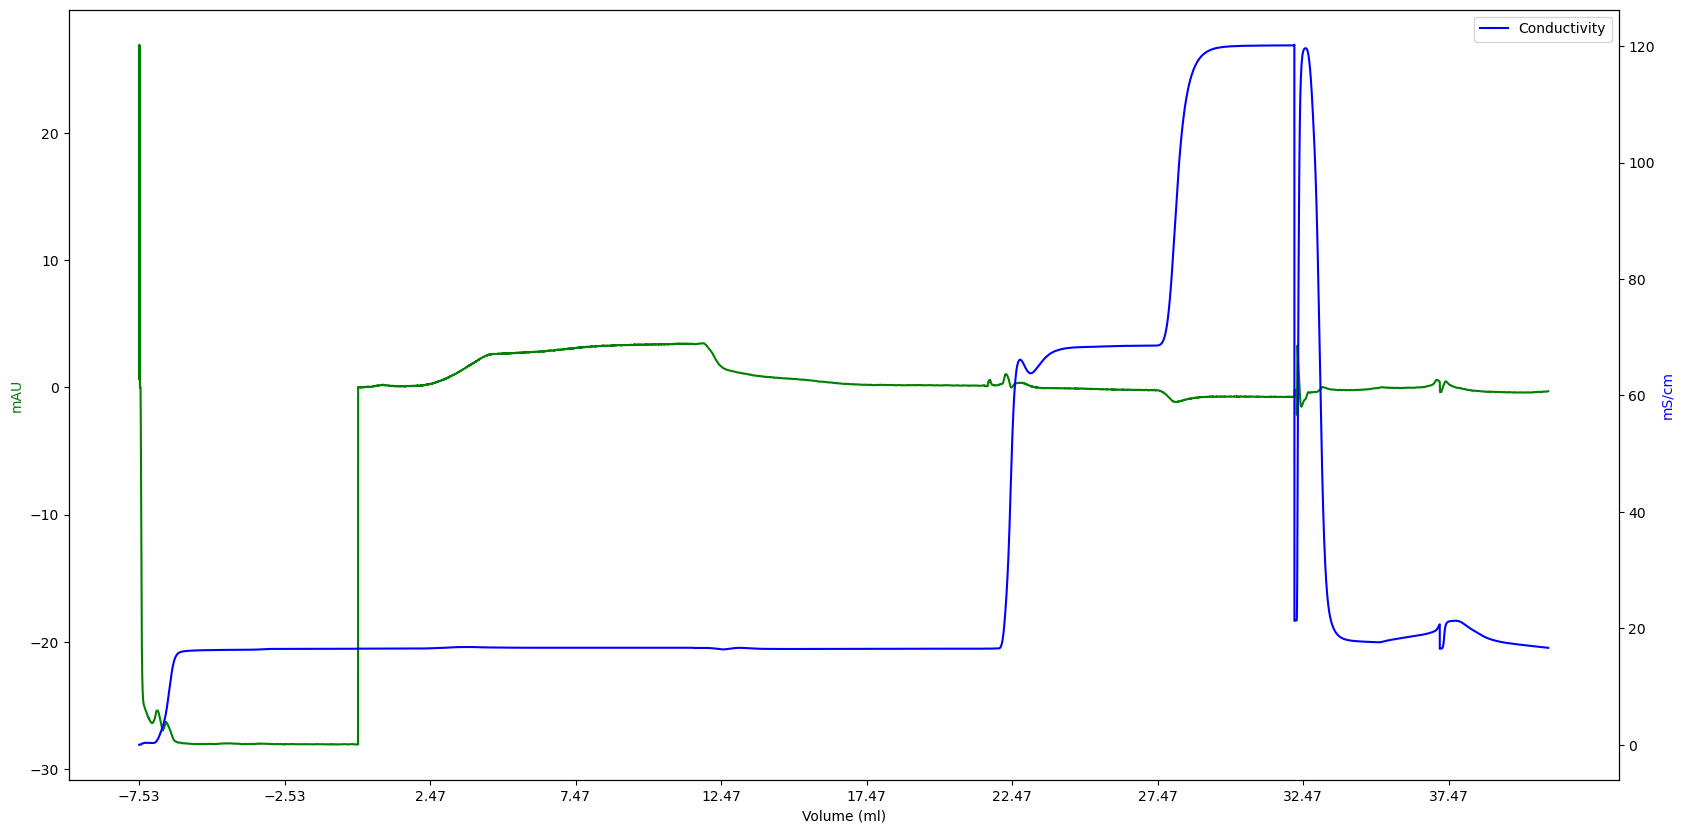

In [13]:
plot_data(dat, data)